In [1]:
# Import necessary libraries/modules
import vertica_python
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os

In [2]:
# Set up the Vertica Connection Information
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')

conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False
            }

connection = vertica_python.connect(**conn_info)
cur = connection.cursor('dict')

In [28]:
# Looking at what data points will be missing from our data set
# Primarily based on business_intelligence.course_master
# business_intelligence.course_master has ~4000+ course_ids to start before we filter out courses missing data

query = """
SELECT
    pacing_type,
    COUNT(*) AS courses
FROM
    business_intelligence.course_master
GROUP BY
    pacing_type;
"""

cur.execute(query)

cm = pd.DataFrame(cur.fetchall())

cm

# Not a significant amount of enrollments for courses missing pacing type
# With the exception of course-v1:MITx+6.002x+MITx_2012_Alumni which has 150K enrollments
# This might be the one off course Circuits and Electronics that had a ton of people moved
# We can probably feel pretty safe removing those courses from the data set

,pacing_type,courses
0,instructor_paced,2714
1,self_paced,1158
2,None,358


In [35]:
# Looking at distribution by pacing type for courses that have ended
query = """
SELECT
    pacing_type,
    COUNT(*) AS courses
FROM
    business_intelligence.course_master
WHERE
    course_end_date <= CURRENT_DATE()
GROUP BY
    pacing_type;
"""

cur.execute(query)

df = pd.DataFrame(cur.fetchall())

df

# We have a decent sample of instructor paced courses that have ended
# However, not as many self paced courses that have ended
# This could be due to Self Paced courses being open longer

,pacing_type,courses
0,instructor_paced,1913
1,self_paced,475
2,None,27


In [45]:
# How do we increase sample size of Self Paced courses knowing that these courses are open longer?
query = """
SELECT
    pacing_type,
    COUNT(*) AS courses
FROM
    business_intelligence.course_master
WHERE
    course_start_date + 90 <= CURRENT_DATE()
GROUP BY
    pacing_type;
"""

cur.execute(query)

df = pd.DataFrame(cur.fetchall())

df

# If we look at Self Paced courses that have started for at least 90 days
# We can almost double the sample size

,pacing_type,courses
0,self_paced,767
1,instructor_paced,1992


In [55]:
# Putting together a query to look at course announce, start, end, and verification date distributions
# We have courses without announcement dates or with announcement dates that come after the start date

query = """
SELECT
	DATEDIFF(day, course_announcement_date, course_start_date) AS announcement_window,
	*
FROM
	business_intelligence.course_master
WHERE
	course_announcement_date <= CURRENT_DATE()
AND
	DATEDIFF(day, course_announcement_date, course_start_date) >= 0
AND
    pacing_type IS NOT NULL
"""

cur.execute(query)

announcement = pd.DataFrame(cur.fetchall())

[(0, 300)]

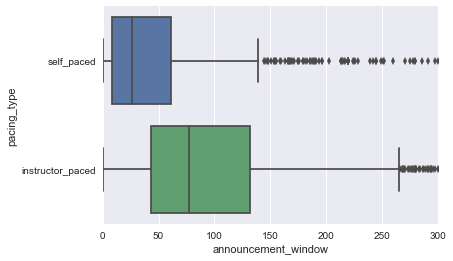

In [56]:
# Here we see instructor paced courses tend to have a longer announcement window

ax = sns.boxplot(x=announcement['announcement_window'], y=announcement['pacing_type'])
ax.set(xlim=(0, 300))

In [60]:
# Looking at course open length; when content is available (Start to End Date)

query = """
SELECT
	DATEDIFF(day, course_start_date, course_end_date) AS course_open_length,
	*
FROM
	business_intelligence.course_master
WHERE
	DATEDIFF(day, course_start_date, course_end_date) > 0;
"""

cur.execute(query)

open_length = pd.DataFrame(cur.fetchall())

[(0, 800)]

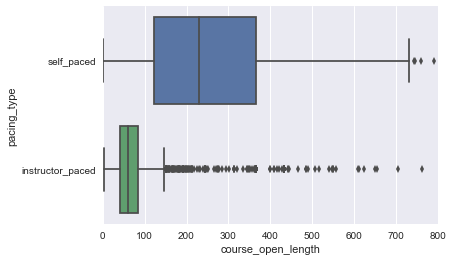

In [65]:
# Self Paced Courses are open much longer than instructor paced courses

ax = sns.boxplot(x=open_length['course_open_length'], y=open_length['pacing_type'])
ax.set(xlim=(0, 800))

In [71]:
# Looking at course verification window (Start to Verification End Date)

query = """
SELECT
	DATEDIFF(day, course_start_date, course_verification_end_date) AS course_verification_window,
	*
FROM
	business_intelligence.course_master
WHERE
	DATEDIFF(day, course_start_date, course_verification_end_date) > 0;
"""

cur.execute(query)

verification_window = pd.DataFrame(cur.fetchall())

[(0, 800)]

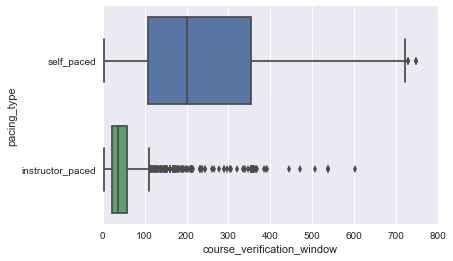

In [72]:
# In line with course length, course verification window is much longer for self paced courses than instructor paced

ax = sns.boxplot(x=verification_window['course_verification_window'], y=verification_window['pacing_type'])
ax.set(xlim=(0, 800))

In [ ]:
# Most of our course offerings are in English though we have more spanish language courses coming up

query = """
SELECT
	content_language,
	COUNT(*) AS courses
FROM
	business_intelligence.course_master
WHERE
	content_language IS NOT NULL
AND
	pacing_type IS NOT NULL
AND
	course_end_date <= CURRENT_DATE()
GROUP BY
	1
"""

In [ ]:
# Enrollment/Verification Depreciation per Course Run Number

query = """
SELECT
	course_run_number,
	COUNT(*) AS course_runs,
	SUM(sum_enrolls) AS enrollments,
	SUM(sum_verifications) AS verifications,
	SUM(sum_enrolls)/COUNT(*) AS enrolls_per_course_run,
	SUM(sum_verifications)/COUNT(*) AS verifications_per_course_run
FROM
	business_intelligence.course_master a
LEFT JOIN
	business_intelligence.course_stats_summary b
ON
	a.course_id = b.course_id
GROUP BY
	course_run_number;
"""